<a href="https://colab.research.google.com/github/csargin/Dog_breed_identification/blob/main/Global_ai_Dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

https://www.kaggle.com/competitions/dog-breed-identification

You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal is to create a classifier capable of determining a dog's breed from a photo.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import cv2 as cv

# Load dataset from kaggle

In [2]:
#https://www.kaggle.com/discussions/general/74235

! pip install -q kaggle
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json

from google.colab import userdata

# make new JSON file
with open('/content/kaggle.json', 'w') as f:
  text = '{"username":"' + userdata.get("kaggle_username") + '","key":"' + userdata.get('kaggle_psw') + '"}'
  f.write(text)

! chmod 600 ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                            title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                             29MB  2023-11-16 01:38:36            708         90  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56           1176         98  1.0              
thedrcat/daigt-proper-train-dataset                            DAIGT Proper Train Dataset                        119MB  2023-11-05 14:03:25           1178        117  1.0              
giabchnguyn/ave

In [3]:
! kaggle competitions download -c 'dog-breed-identification'

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip -o dog-breed-identification.zip -d dog-breed-identification # unzip in order to overwrite files

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: dog-breed-identification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog-breed-identification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog-breed-identification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog-breed-identification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog-breed-identification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog-breed-identification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog-breed-identification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog-breed-identification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog-breed-identification/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog-breed-identification/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog-breed-identification/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog-breed-identification/tr

In [5]:
train_dir = './dog-breed-identification/train/'
test_dir = './dog-breed-identification/test/'
df = pd.read_csv('./dog-breed-identification/labels.csv') # Load the labels

In [6]:
! ls ./dog-breed-identification/train/ | wc -l

10222


# Preprocessing

In [7]:
encoder = LabelEncoder()
refactor_size = 128

# training and validation data
path = train_dir
df['image'] = df['id'].apply(lambda x: x + ".jpg")
df['category'] = encoder.fit_transform(df["breed"].values)
df.head()

,id,breed,image,category
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg,49


In [8]:
def load_and_preprocess_image(image_path, target_shape):
    img = plt.imread(image_path, 0)
    img = cv.resize(img, (target_shape,target_shape))
    img = img/255

    return img

In [9]:
X = []
y= []
for index, row in df.iterrows():
    image_path = os.path.join(path, row["image"])
    img = load_and_preprocess_image(image_path ,refactor_size )
    X.append( img)
    y.append( row["category"] )


Text(0.5, 1.0, '37')

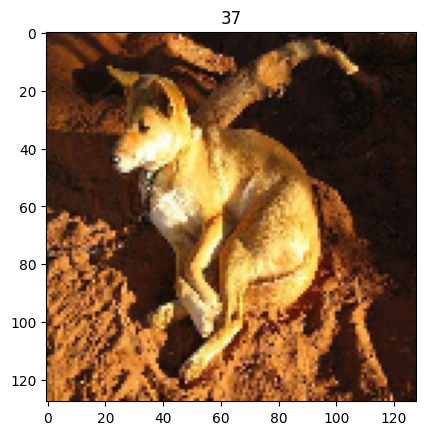

In [10]:
plt.imshow(X[1])
plt.title(y[1])

In [11]:
X= np.array(X[:5000])
y= np.array(y[:5000])

X_train, X_val, y_train, y_val = train_test_split(X, y,random_state=30)

print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

3750
1250
3750
1250


In [12]:
import pickle

if "pickles" not in os.listdir():
    os.mkdir("pickles")

with open("pickles/X_train.pickle", "wb") as f:
  pickle.dump(X_train, f)
with open("pickles/y_train.pickle", "wb") as f:
  pickle.dump(y_train, f)

with open("pickles/X_val.pickle", "wb") as f:
  pickle.dump(X_val, f)
with open("pickles/y_val.pickle", "wb") as f:
  pickle.dump(y_val, f)

# Model

In [13]:
model = models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(120, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[checkpoint])

Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 4.8082 - accuracy: 0.0109
Epoch 1: val_accuracy improved from -inf to 0.00880, saving model to best_model.h5
118/118 [==============================] - 120s 1s/step - loss: 4.8082 - accuracy: 0.0109 - val_loss: 4.7867 - val_accuracy: 0.0088
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - ETA: 0s - loss: 4.6633 - accuracy: 0.0251
Epoch 2: val_accuracy improved from 0.00880 to 0.02080, saving model to best_model.h5
118/118 [==============================] - 127s 1s/step - loss: 4.6633 - accuracy: 0.0251 - val_loss: 4.6264 - val_accuracy: 0.0208
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 4.3817 - accuracy: 0.0568
Epoch 3: val_accuracy improved from 0.02080 to 0.02960, saving model to best_model.h5
118/118 [==============================] - 118s 1s/step - loss: 4.3817 - accuracy: 0.0568 - val_loss: 4.5348 - val_accuracy: 0.0296
Epoch 4/100
118/118 [==============================] - ETA: 0s - loss: 4.0157 - accuracy: 0.1341
Epoch 4: val_accuracy improved from 0.02960 to 0.05040, saving model to best_model.h5
118/118 [==============================] - 118s 1s/step - loss: 4.0157 - accuracy: 0.1341 - val_loss: 4.4616 - val_accuracy: 0.0504
Epoch 5/100
118/118 [==============================] - ETA: 0s - lo

In [ ]:
best_model = models.load_model('best_model.h5')

In [ ]:
test_loss, best_test_acc = best_model.evaluate(X_val, y_val, verbose=2)
print("\nBest Test Accuracy:", best_test_acc)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
best_predictions = best_model.predict(X_val)
best_predicted_classes = np.argmax(best_predictions, axis=1)

In [ ]:
best_cm = confusion_matrix(y_val, best_predicted_classes)
plt.figure(figsize=(120,120))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=df['breed'].unique(), yticklabels=df['breed'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
plt.suptitle('First 20 Predicted Images with Predicted Classes', size=20)
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_val[i])
    predicted_class_label = df['breed'][best_predicted_classes[i]]
    actual_class_label = df['breed'][y_val[i]]

    if best_predicted_classes[i] == y_val[i]:
        title_color = 'green'
    else:
        title_color = 'red'

    title = f'Predicted Class: {predicted_class_label}\nActual Class: {actual_class_label}'
    plt.title(title, color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()